In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [2]:
class City:
    """Class to create city objects with given x and y coordinates
        represents gene in genetic algorithm"""

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        """Find distance for given city"""

        x_dist = abs(self.x - city.x)
        y_dist = abs(self.y - city.y)
        distance = np.sqrt((x_dist ** 2) + (y_dist ** 2))

        return distance

    def __repr__(self):
        return f"({str(self.x)}, {str(self.y)})"

In [3]:
class Fitness:
    """Class for the fitness function needed for genetic algorithm
        how fast the route is"""

    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def route_distance(self):
        """Find the route distance"""

        if self.distance == 0:
            path_distance = 0
            for i in range(0, len(self.route)):
                from_city = self.route[i]
                to_city = None
                if i + 1 < len(self.route):
                    to_city = self.route[i + 1]
                else:
                    to_city = self.route[0]
                path_distance += from_city.distance(to_city)
            self.distance = path_distance

        return self.distance

    def route_fitness(self):
        """Determine fitness of given route
            inverse of distance"""

        if self.fitness == 0:
            self.fitness = 1 / float(self.route_distance())

        return self.fitness

In [4]:
def create_route(city_list):
    """Create route given list of cities
        creating a single individual"""

    route = random.sample(city_list, len(city_list))
    return route

In [5]:
def create_routes(city_list, num_routes):
    """Create first list of routes (population)
        createing entire population of individuals"""

    population = []

    for i in range(0, num_routes):
        population.append(create_route(city_list))
    return population

In [6]:
def rank_routes(routes):
    """Rank routes by fitness and get most fit route(best)
        survival of the fittest"""

    fitness_results = {}

    for i in range(0, len(routes)):
        fitness_results[i] = Fitness(routes[i]).route_fitness()

    return sorted(
        fitness_results.items(), key=operator.itemgetter(1), reverse=True
    )

In [7]:
def selection_func(routes_ranked, elite_size):
    """Select most appropriate routes to 
        use and persist routes with best fitness(distance)"""

    selection_results = []
    df = pd.DataFrame(np.array(routes_ranked), columns=["Index", "Fitness"])
    df["cum_sum"] = df.Fitness.cumsum()
    df["cum_perc"] = 100 * df.cum_sum / df.Fitness.sum()

    # keep best routes, Elitism.
    for i in range(0, elite_size):
        selection_results.append(routes_ranked[i][0])

    # random selection of routes
    for i in range(0, len(routes_ranked) - elite_size):
        pick = 100 * random.random()
        for i in range(0, len(routes_ranked)):
            if pick <= df.iat[i, 3]:
                selection_results.append(routes_ranked[i][0])
                break

    return selection_results

In [8]:
def select_routes(routes, selection_results):
    """Extract a subset of routes via selection function
        considered the mating pool"""

    selected_routes = []

    for i in range(0, len(selection_results)):
        index = selection_results[i]
        selected_routes.append(routes[index])

    return selected_routes

In [9]:
def combine_route(route1, route2):
    """Combine routes together to create an extended route
        breeding with mating pool (ordered crossover)
        create single offspring"""

    child_route = []
    parent_route1 = []
    parent_route2 = []

    partial_route1 = int(random.random() * len(route1))
    partial_route2 = int(random.random() * len(route2))

    start_route = min(partial_route1, partial_route2)
    end_route = max(partial_route1, partial_route2)

    for i in range(start_route, end_route):
        parent_route1.append(route1[i])

    parent_route2 = [item for item in route2 if item not in parent_route1]
    child_route = parent_route1 + parent_route2

    return child_route

In [10]:
def combine_routes(routes, elite_size):
    """Keep best routes then use combine routes
       function to create different route combos
       create population of offspring"""

    new_routes = []
    length = len(routes) - elite_size
    pool = random.sample(routes, len(routes))

    # Keep best routes from list of routes, elitism.
    for i in range(0, elite_size):
        new_routes.append(routes[i])

    for i in range(0, length):
        new_route = combine_route(pool[i], pool[len(routes) - i - 1])
        new_routes.append(new_route)

    return new_routes

In [11]:
def swap_route(route, swap_rate):
    """Swap cities with each other to be able to change route combinations
        mutations in the population (due to restrictions of including all
        cities, no dropping of cities) swap_rate = mutation rate"""

    for swapped in range(len(route)):
        if random.random() < swap_rate:
            swap_with = int(random.random() * len(route))

            city1, city2 = route[swapped], route[swap_with]

            route[swapped], route[swap_with] = city2, city1

    return route

In [12]:
def swap_routes(routes, swap_rate):
    """Apply swap route function across all routes
        apply mutation throughout entire population"""

    swapped_routes = []

    for idx in range(0, len(routes)):
        swapped_route = swap_route(routes[idx], swap_rate)
        swapped_routes.append(swapped_route)

    return swapped_routes

In [13]:
def new_route(curr_route, elite_size, swap_rate):
    """Use earlier functions in order to
       create a new route to visit all points
       create a new generation"""

    # Find fit individuals
    ranked_routes = rank_routes(curr_route)
    # Potential parents
    selection_results = selection_func(ranked_routes, elite_size)
    # Create mating pool
    selected_routes = select_routes(curr_route, selection_results)
    # Breed to create new generation
    routes = combine_routes(selected_routes, elite_size)
    # Apply mutations
    new_routes = swap_routes(routes, swap_rate)

    return new_routes

In [14]:
def fastest_route(cities_list, num_routes, elite_size, swap_rate, generations):
    """Function to find fastest route to visit all cities only once"""

    route = create_routes(cities_list, num_routes)

    # Set generation to 50 feel free to change for more route possibilities
    for i in range(0, generations):
        route = new_route(route, elite_size, swap_rate)

    best_route_index = rank_routes(route)[0][0]
    best_route = route[best_route_index]

    return best_route

In [15]:
cities = [{"x":116,"y":404},{"x":161,"y":617},{"x":16,"y":97},{"x":430,"y":536},{"x":601,"y":504},{"x":425,"y":461},{"x":114,"y":544},{"x":127,"y":118},{"x":163,"y":357},{"x":704,"y":104},{"x":864,"y":125},{"x":847,"y":523},{"x":742,"y":170},{"x":204,"y":601},{"x":421,"y":377},{"x":808,"y":49},{"x":860,"y":466},{"x":844,"y":294},{"x":147,"y":213},{"x":550,"y":124},{"x":238,"y":313},{"x":57,"y":572},{"x":664,"y":190},{"x":612,"y":644},{"x":456,"y":154},{"x":120,"y":477},{"x":542,"y":313},{"x":620,"y":29},{"x":245,"y":246},{"x":611,"y":578},{"x":627,"y":373},{"x":534,"y":286},{"x":577,"y":545},{"x":539,"y":340},{"x":794,"y":328},{"x":855,"y":139},{"x":700,"y":47},{"x":275,"y":593},{"x":130,"y":196},{"x":863,"y":35}]

In [16]:
cities_list = [
            City(x=tuple(d.values())[0], y=tuple(d.values())[1])
            for d in cities
        ]

In [17]:
cities_list

[(116, 404),
 (161, 617),
 (16, 97),
 (430, 536),
 (601, 504),
 (425, 461),
 (114, 544),
 (127, 118),
 (163, 357),
 (704, 104),
 (864, 125),
 (847, 523),
 (742, 170),
 (204, 601),
 (421, 377),
 (808, 49),
 (860, 466),
 (844, 294),
 (147, 213),
 (550, 124),
 (238, 313),
 (57, 572),
 (664, 190),
 (612, 644),
 (456, 154),
 (120, 477),
 (542, 313),
 (620, 29),
 (245, 246),
 (611, 578),
 (627, 373),
 (534, 286),
 (577, 545),
 (539, 340),
 (794, 328),
 (855, 139),
 (700, 47),
 (275, 593),
 (130, 196),
 (863, 35)]

In [20]:
routes = create_routes(cities_list, 100)

In [21]:
routes

[[(704, 104),
  (275, 593),
  (539, 340),
  (238, 313),
  (601, 504),
  (542, 313),
  (863, 35),
  (114, 544),
  (16, 97),
  (421, 377),
  (245, 246),
  (577, 545),
  (550, 124),
  (611, 578),
  (161, 617),
  (127, 118),
  (742, 170),
  (627, 373),
  (664, 190),
  (855, 139),
  (147, 213),
  (808, 49),
  (430, 536),
  (847, 523),
  (130, 196),
  (163, 357),
  (425, 461),
  (204, 601),
  (620, 29),
  (120, 477),
  (844, 294),
  (612, 644),
  (534, 286),
  (864, 125),
  (456, 154),
  (57, 572),
  (860, 466),
  (700, 47),
  (116, 404),
  (794, 328)],
 [(550, 124),
  (120, 477),
  (742, 170),
  (860, 466),
  (534, 286),
  (601, 504),
  (704, 104),
  (855, 139),
  (664, 190),
  (204, 601),
  (161, 617),
  (864, 125),
  (627, 373),
  (57, 572),
  (539, 340),
  (238, 313),
  (163, 357),
  (127, 118),
  (612, 644),
  (794, 328),
  (16, 97),
  (421, 377),
  (245, 246),
  (456, 154),
  (844, 294),
  (611, 578),
  (147, 213),
  (577, 545),
  (430, 536),
  (275, 593),
  (700, 47),
  (425, 461),
  

In [22]:
ranked_routes = rank_routes(routes)

In [23]:
ranked_routes

[(56, 6.999215552337202e-05),
 (77, 6.813368377230148e-05),
 (96, 6.77470029013725e-05),
 (92, 6.751039432501307e-05),
 (93, 6.544681337550761e-05),
 (62, 6.537961547386392e-05),
 (39, 6.531578300321184e-05),
 (10, 6.531387771387259e-05),
 (15, 6.485017710155143e-05),
 (78, 6.466432732471573e-05),
 (90, 6.357255508912249e-05),
 (41, 6.347309394763284e-05),
 (98, 6.331642071034643e-05),
 (14, 6.301658739424579e-05),
 (81, 6.274956691017739e-05),
 (28, 6.24721346372709e-05),
 (4, 6.242932284685886e-05),
 (64, 6.219584229092438e-05),
 (80, 6.215314906124902e-05),
 (33, 6.211468189508679e-05),
 (11, 6.190678557676286e-05),
 (12, 6.184754469429351e-05),
 (65, 6.175480781703237e-05),
 (68, 6.163319316718186e-05),
 (46, 6.162620084788351e-05),
 (9, 6.161245403253178e-05),
 (6, 6.160402600509385e-05),
 (82, 6.125648601437912e-05),
 (1, 6.11800503975172e-05),
 (30, 6.097254761126615e-05),
 (35, 6.093553133376114e-05),
 (38, 6.076908933868335e-05),
 (79, 6.074910920015263e-05),
 (18, 6.069308740

In [24]:
selection_results = selection_func(ranked_routes, 20)

In [25]:
selection_results

[56,
 77,
 96,
 92,
 93,
 62,
 39,
 10,
 15,
 78,
 90,
 41,
 98,
 14,
 81,
 28,
 4,
 64,
 80,
 33,
 91,
 60,
 1,
 84,
 25,
 11,
 42,
 71,
 48,
 99,
 80,
 52,
 67,
 18,
 67,
 74,
 95,
 67,
 70,
 40,
 24,
 75,
 10,
 4,
 91,
 25,
 20,
 36,
 39,
 85,
 77,
 35,
 25,
 68,
 55,
 9,
 27,
 4,
 64,
 29,
 35,
 28,
 20,
 95,
 19,
 14,
 35,
 44,
 91,
 92,
 56,
 13,
 82,
 89,
 99,
 33,
 77,
 64,
 98,
 94,
 80,
 43,
 45,
 3,
 17,
 13,
 5,
 63,
 90,
 64,
 76,
 22,
 58,
 49,
 44,
 49,
 39,
 67,
 59,
 75]

In [26]:
selected_routes = select_routes(routes, selection_results)

In [27]:
selected_routes

[[(238, 313),
  (700, 47),
  (664, 190),
  (808, 49),
  (542, 313),
  (863, 35),
  (620, 29),
  (860, 466),
  (847, 523),
  (275, 593),
  (794, 328),
  (127, 118),
  (114, 544),
  (147, 213),
  (161, 617),
  (245, 246),
  (163, 357),
  (577, 545),
  (430, 536),
  (421, 377),
  (612, 644),
  (742, 170),
  (425, 461),
  (130, 196),
  (204, 601),
  (120, 477),
  (116, 404),
  (627, 373),
  (550, 124),
  (456, 154),
  (601, 504),
  (16, 97),
  (704, 104),
  (855, 139),
  (864, 125),
  (539, 340),
  (611, 578),
  (534, 286),
  (844, 294),
  (57, 572)],
 [(430, 536),
  (847, 523),
  (204, 601),
  (238, 313),
  (161, 617),
  (275, 593),
  (855, 139),
  (664, 190),
  (539, 340),
  (863, 35),
  (704, 104),
  (542, 313),
  (860, 466),
  (794, 328),
  (612, 644),
  (16, 97),
  (130, 196),
  (245, 246),
  (844, 294),
  (147, 213),
  (577, 545),
  (425, 461),
  (601, 504),
  (116, 404),
  (120, 477),
  (534, 286),
  (127, 118),
  (57, 572),
  (456, 154),
  (700, 47),
  (742, 170),
  (611, 578),
  (

In [28]:
combined_routes = combine_routes(selected_routes, 20)

In [29]:
combined_routes

[[(238, 313),
  (700, 47),
  (664, 190),
  (808, 49),
  (542, 313),
  (863, 35),
  (620, 29),
  (860, 466),
  (847, 523),
  (275, 593),
  (794, 328),
  (127, 118),
  (114, 544),
  (147, 213),
  (161, 617),
  (245, 246),
  (163, 357),
  (577, 545),
  (430, 536),
  (421, 377),
  (612, 644),
  (742, 170),
  (425, 461),
  (130, 196),
  (204, 601),
  (120, 477),
  (116, 404),
  (627, 373),
  (550, 124),
  (456, 154),
  (601, 504),
  (16, 97),
  (704, 104),
  (855, 139),
  (864, 125),
  (539, 340),
  (611, 578),
  (534, 286),
  (844, 294),
  (57, 572)],
 [(430, 536),
  (847, 523),
  (204, 601),
  (238, 313),
  (161, 617),
  (275, 593),
  (855, 139),
  (664, 190),
  (539, 340),
  (863, 35),
  (704, 104),
  (542, 313),
  (860, 466),
  (794, 328),
  (612, 644),
  (16, 97),
  (130, 196),
  (245, 246),
  (844, 294),
  (147, 213),
  (577, 545),
  (425, 461),
  (601, 504),
  (116, 404),
  (120, 477),
  (534, 286),
  (127, 118),
  (57, 572),
  (456, 154),
  (700, 47),
  (742, 170),
  (611, 578),
  (

In [30]:
new_routes = swap_routes(combined_routes, .01)

In [31]:
new_routes

[[(238, 313),
  (700, 47),
  (664, 190),
  (808, 49),
  (542, 313),
  (863, 35),
  (620, 29),
  (860, 466),
  (847, 523),
  (275, 593),
  (794, 328),
  (127, 118),
  (114, 544),
  (147, 213),
  (161, 617),
  (245, 246),
  (163, 357),
  (577, 545),
  (430, 536),
  (421, 377),
  (612, 644),
  (742, 170),
  (425, 461),
  (130, 196),
  (204, 601),
  (120, 477),
  (116, 404),
  (627, 373),
  (550, 124),
  (456, 154),
  (601, 504),
  (16, 97),
  (704, 104),
  (855, 139),
  (864, 125),
  (539, 340),
  (611, 578),
  (534, 286),
  (844, 294),
  (57, 572)],
 [(430, 536),
  (847, 523),
  (204, 601),
  (238, 313),
  (161, 617),
  (275, 593),
  (855, 139),
  (664, 190),
  (539, 340),
  (863, 35),
  (704, 104),
  (542, 313),
  (860, 466),
  (794, 328),
  (612, 644),
  (16, 97),
  (130, 196),
  (245, 246),
  (844, 294),
  (147, 213),
  (577, 545),
  (425, 461),
  (601, 504),
  (116, 404),
  (120, 477),
  (534, 286),
  (127, 118),
  (57, 572),
  (456, 154),
  (700, 47),
  (742, 170),
  (611, 578),
  (

In [32]:
best_route_index = rank_routes(new_routes)[0][0]

In [33]:
best_route_index

24

In [34]:
best_route = new_routes[best_route_index]

In [35]:
best_route

[(664, 190),
 (539, 340),
 (577, 545),
 (430, 536),
 (847, 523),
 (204, 601),
 (238, 313),
 (161, 617),
 (275, 593),
 (855, 139),
 (863, 35),
 (704, 104),
 (542, 313),
 (860, 466),
 (794, 328),
 (612, 644),
 (16, 97),
 (130, 196),
 (245, 246),
 (844, 294),
 (147, 213),
 (425, 461),
 (601, 504),
 (116, 404),
 (120, 477),
 (534, 286),
 (127, 118),
 (57, 572),
 (456, 154),
 (700, 47),
 (742, 170),
 (611, 578),
 (864, 125),
 (808, 49),
 (627, 373),
 (114, 544),
 (163, 357),
 (550, 124),
 (421, 377),
 (620, 29)]

In [36]:
def fastest_route_plot(cities_list, num_routes, elite_size, swap_rate, generations):
    """Function to find fastest route to visit all cities only once"""

    routes = create_routes(cities_list, num_routes)
    progress = []
    progress.append(1 / rank_routes(routes)[0][1])

    # Set generation to 50 feel free to change for more route possibilities
    for i in range(0, generations):
        routes = new_route(routes, elite_size, swap_rate)
        progress.append(1 /rank_routes(routes)[0][1])

    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

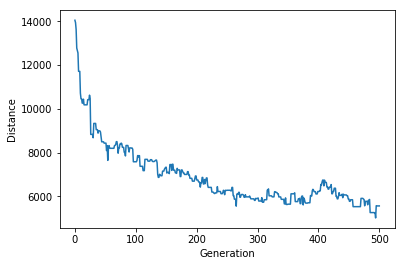

In [40]:
fastest_route_plot(cities_list, num_routes=250, elite_size=20, swap_rate=0.01, generations=500)